# Meteor Project -  Directions of interest

In this script we will add the position of the Sun and some more... "sky features" to understand the radiant distribution that has been shown in the last script

## Get and prepare the data

The code part here is a compressed version from last time. In the last cell of this section we will add a new column that provides the Day of Year (DOY). We will iterate through the DOY (aggregated for all years) and create a DOY sky map of radiants.

In [1]:
# Importing libraries
from matplotlib import pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd

import datetime
import math
import os

In [2]:
# Read in the meteor data
df_orbit_compl = pd.read_csv("meteor_data/meteor_compl.csv",
                             index_col=0)
df_orbit_error = pd.read_csv("meteor_data/meteor_error.csv",
                             index_col=0)

df_radiants = pd.concat([df_orbit_compl[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]],
                         df_orbit_error[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]]])

# Now filter
df_radiants = df_radiants.loc[(df_radiants["Vg"]>=11) & (df_radiants["Vg"]<=73)].copy()

# Convert to radians
df_radiants.loc[:, "RA_rad"] = np.radians(df_radiants["RA"])
df_radiants.loc[:, "DECL_rad"] = np.radians(df_radiants["DECL"])

# Add a column for the plot
df_radiants.loc[:, 'RA_rad4plot'] = \
    df_radiants['RA_rad'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

# First we add a datetime object column:
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: datetime.datetime(year=int(x["Yr"]),
                                                  month=int(x["Mn"]),
                                                  day=math.floor(x["Dayy"])),
                                                  axis=1)

# Add now the day's fraction
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: x["datetime"] + datetime.timedelta(days=x["Dayy"]%1), axis=1)

# Add a Day of Year (DOY) column, based on the datetime column
df_radiants.loc[:, "doy"] = df_radiants.datetime.dt.day_of_year.copy()

## Add the Sun's position, the Apex, Anti-Apex and Antihelion coordiantes

In [3]:
# Load SPICE kernels
import spiceypy
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/spk/de432s.bsp")

In [4]:
# Compute emphermis time
df_radiants.loc[:, "ET"] = \
    df_radiants.apply(lambda x: spiceypy.utc2et(x["datetime"].strftime("%Y-%m-%dT%H:%M:%S")),
                                                axis=1)

In [5]:
# Compute the following vectors per ET:
# - Direction to Sun as seen from Earth
# - Direction to Apex as seen from Earth
# - Direction to Antihelion as seen from Earth
# - Direction to Anti-Apex as seen from Earth
df_radiants.loc[:, "Helion_vec"] = \
    df_radiants.apply(lambda x: np.array(spiceypy.spkgps(targ=10,
                                                         et=x["ET"],
                                                         ref="J2000",
                                                         obs=399)[0]),
                      axis=1)

# For the Apex we compute the velocity vector of Earth w.r.t. the Sun
df_radiants.loc[:, "Apex_vec"] = \
    df_radiants.apply(lambda x: np.array(spiceypy.spkgeo(targ=399,
                                                         et=x["ET"],
                                                         ref="J2000",
                                                         obs=10)[0][3:]),
                      axis=1)

# Antihelion: simply invert the Sun's vector
df_radiants.loc[:, "Antihelion_vec"] = \
    df_radiants.apply(lambda x: -1.0*x["Helion_vec"],
                      axis=1)

# Antiapex: simply invert the Apex' vector
df_radiants.loc[:, "Antiapex_vec"] = \
    df_radiants.apply(lambda x: -1.0*x["Apex_vec"],
                      axis=1)

In [6]:
# Let's check the angles:
def angle_between_vectors(v1, v2):

    # Calculate the dot product of the vectors
    dot_product = np.dot(v1, v2)

    # Calculate the magnitude of the vectors
    v1_magnitude = np.linalg.norm(v1)
    v2_magnitude = np.linalg.norm(v2)

    # Calculate the cosine of the angle between the vectors
    cosine_of_angle = dot_product / (v1_magnitude * v2_magnitude)

    # Calculate the angle between the vectors
    angle = np.arccos(cosine_of_angle)

    # ... in degrees
    angle = np.degrees(angle)
    
    return angle

# We take the first entry only
antihelion_helion_angle = angle_between_vectors(df_radiants.iloc[0]['Helion_vec'],
                                                df_radiants.iloc[0]['Antihelion_vec'])

antiapex_apex_angle = angle_between_vectors(df_radiants.iloc[0]['Apex_vec'],
                                            df_radiants.iloc[0]['Antiapex_vec'])

helion_apex_angle = angle_between_vectors(df_radiants.iloc[0]['Helion_vec'],
                                          df_radiants.iloc[0]['Apex_vec'])

print(f"Angle between Helion and Antihelion direction in degrees: {antihelion_helion_angle}")
print(f"Angle between Apex and Antiapex direction in degrees: {antiapex_apex_angle}")
print(f"Angle between Apex and Helio direction in degrees: {helion_apex_angle}")

Angle between Helion and Antihelion direction in degrees: 180.0
Angle between Apex and Antiapex direction in degrees: 180.0
Angle between Apex and Helio direction in degrees: 89.95945617005991


In [7]:
# Converting the vectors to sky coordiantes
df_radiants.loc[:, "Helion_RA"] = df_radiants["Helion_vec"].apply(lambda x: spiceypy.recrad(x)[1])
df_radiants.loc[:, "Helion_Dec"] = df_radiants["Helion_vec"].apply(lambda x: spiceypy.recrad(x)[2])
df_radiants.loc[:, 'Helion_RA_rad4plot'] = \
    df_radiants['Helion_RA'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

df_radiants.loc[:, "Antihelion_RA"] = df_radiants["Antihelion_vec"].apply(lambda x: spiceypy.recrad(x)[1])
df_radiants.loc[:, "Antihelion_Dec"] = df_radiants["Antihelion_vec"].apply(lambda x: spiceypy.recrad(x)[2])
df_radiants.loc[:, 'Antihelion_RA_rad4plot'] = \
    df_radiants['Antihelion_RA'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

df_radiants.loc[:, "Apex_RA"] = df_radiants["Apex_vec"].apply(lambda x: spiceypy.recrad(x)[1])
df_radiants.loc[:, "Apex_Dec"] = df_radiants["Apex_vec"].apply(lambda x: spiceypy.recrad(x)[2])
df_radiants.loc[:, 'Apex_RA_rad4plot'] = \
    df_radiants['Apex_RA'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

df_radiants.loc[:, "Antiapex_RA"] = df_radiants["Antiapex_vec"].apply(lambda x: spiceypy.recrad(x)[1])
df_radiants.loc[:, "Antiapex_Dec"] = df_radiants["Antiapex_vec"].apply(lambda x: spiceypy.recrad(x)[2])
df_radiants.loc[:, 'Antiapex_RA_rad4plot'] = \
    df_radiants['Antiapex_RA'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

## Sky Plot

... but again in a static fashion

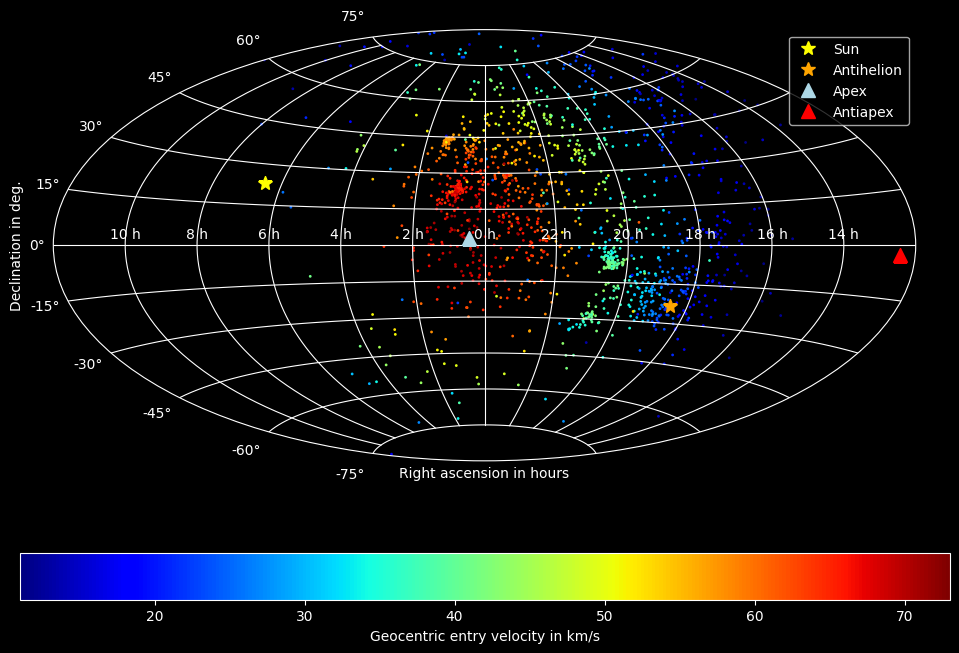

In [8]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))

# Add aitoff projection
plt.subplot(projection="aitoff")

# Get axes
ax = plt.gca()

# Add a color for the velocity values
cm = plt.colormaps.get_cmap('jet')

filtered_df_radiants = df_radiants.loc[df_radiants["doy"]==180].copy()

# Plot the radiants
cr = plt.scatter(filtered_df_radiants['RA_rad4plot'], \
                 filtered_df_radiants['DECL_rad'], linestyle='None', \
                 s=1, c=filtered_df_radiants["Vg"], cmap=cm)

# Create a colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(df_radiants["Vg"].values),
                                                       max(df_radiants["Vg"].values)))

# Add the Sun, Antihelion, Apex and Antiapex direction
plt.plot(filtered_df_radiants.iloc[0]["Helion_RA_rad4plot"],
         filtered_df_radiants.iloc[0]["Helion_Dec"],
         marker="*", lw=0, markersize=10, color="yellow", label="Sun")

plt.plot(filtered_df_radiants.iloc[0]["Antihelion_RA_rad4plot"],
         filtered_df_radiants.iloc[0]["Antihelion_Dec"],
         marker="*", lw=0, markersize=10, color="orange", label="Antihelion")

plt.plot(filtered_df_radiants.iloc[0]["Apex_RA_rad4plot"],
         filtered_df_radiants.iloc[0]["Apex_Dec"],
         marker="^", lw=0, markersize=10, color="lightblue", label="Apex")

plt.plot(filtered_df_radiants.iloc[0]["Antiapex_RA_rad4plot"],
         filtered_df_radiants.iloc[0]["Antiapex_Dec"],
         marker="^", lw=0, markersize=10, color="red", label="Antiapex")

plt.legend()

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

# Add the colorbar
ax = plt.gca()
color_bar = fig.colorbar(sm, orientation='horizontal', ax=ax)
color_bar.set_alpha(1)
color_bar.set_label('Geocentric entry velocity in km/s')

fig.savefig("dir_of_interests.png")